In [2]:
import matplotlib.pyplot as plt
import pickle
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
from collections import Counter

In [3]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pickle
import seaborn as sns

from tqdm import tqdm

## Experiment 1

0.2475019097328186


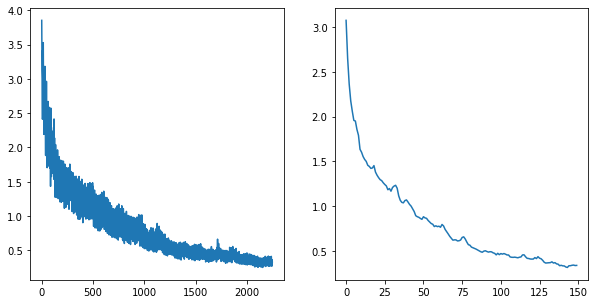

In [4]:
with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_01/epoch_losses.pkl', 'rb') as fp:
    epoch_losses = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_01/step_losses.pkl', 'rb') as fp:
    step_losses = pickle.load(fp)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

print(min(step_losses))

In [5]:
with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_01/X.pkl', 'rb') as fp:
    X = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_01/Y.pkl', 'rb') as fp:
    Y = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_01/Y_pred.pkl', 'rb') as fp:
    Y_pred = pickle.load(fp)

In [6]:
print(X.shape)
print(Y.shape)
print(Y_pred.shape)

(8, 3, 240, 320)
(8, 240, 320, 3)
(8, 240, 320)


In [18]:
print(Y_pred[0].shape)
value = [Y_pred[0], Y_pred[0]]
np.array(value).shape

(240, 320)


(2, 240, 320)

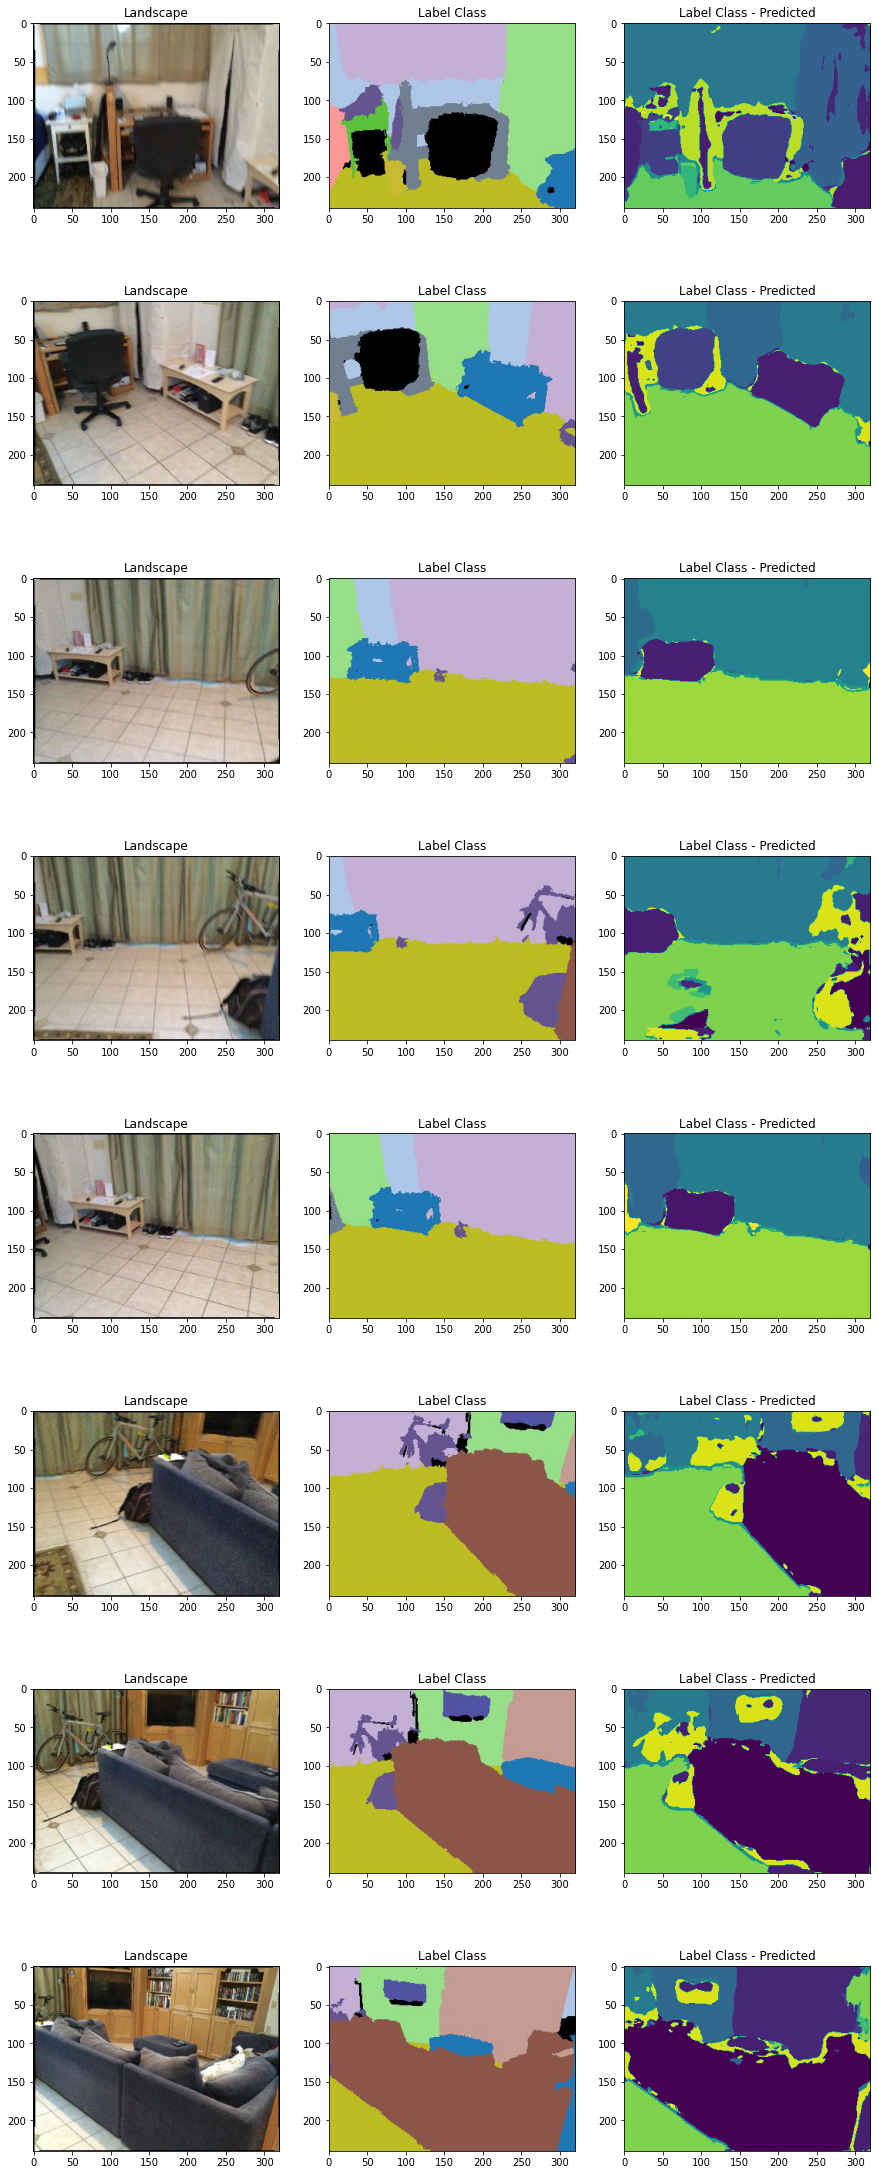

In [7]:
test_batch_size = 8
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(torch.from_numpy(X[i])).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i]
    label_class_predicted = Y_pred[i]
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [11]:
def iou_numpy(outputs: np.array, labels: np.array):
#     outputs = outputs.squeeze(1)
    SMOOTH = 1e-6
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    print(iou)
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()

In [8]:
class Metric(object):
    """Base class for all metrics.

    From: https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py
    """
    def reset(self):
        pass

    def add(self):
        pass

    def value(self):
        pass

class ConfusionMatrix(Metric):
    """Constructs a confusion matrix for a multi-class classification problems.

    Does not support multi-label, multi-class problems.

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem.
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.

    Modified from: https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
    """

    def __init__(self, num_classes, normalized=False):
        super().__init__()

        self.conf = np.ndarray((num_classes, num_classes), dtype=np.int64)
        self.normalized = normalized
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.conf.fill(0)

    def add(self, predicted, target):
        """Computes the confusion matrix

        The shape of the confusion matrix is K x K, where K is the number
        of classes.

        Keyword arguments:
        - predicted (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        predicted scores obtained from the model for N examples and K classes,
        or an N-tensor/array of integer values between 0 and K-1.
        - target (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        ground-truth classes for N examples and K classes, or an N-tensor/array
        of integer values between 0 and K-1.

        """
        # If target and/or predicted are tensors, convert them to numpy arrays
        if torch.is_tensor(predicted):
            predicted = predicted.cpu().numpy()
        if torch.is_tensor(target):
            target = target.cpu().numpy()

        assert predicted.shape[0] == target.shape[0], \
            'number of targets and predicted outputs do not match'

        if np.ndim(predicted) != 1:
            assert predicted.shape[1] == self.num_classes, \
                'number of predictions does not match size of confusion matrix'
            predicted = np.argmax(predicted, 1)
        else:
            assert (predicted.max() < self.num_classes) and (predicted.min() >= 0), \
                'predicted values are not between 0 and k-1'

        if np.ndim(target) != 1:
            assert target.shape[1] == self.num_classes, \
                'Onehot target does not match size of confusion matrix'
            assert (target >= 0).all() and (target <= 1).all(), \
                'in one-hot encoding, target values should be 0 or 1'
            assert (target.sum(1) == 1).all(), \
                'multi-label setting is not supported'
            target = np.argmax(target, 1)
        else:
            assert (target.max() < self.num_classes) and (target.min() >= 0), \
                'target values are not between 0 and k-1'

        # hack for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int64), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        self.conf += conf

    def value(self):
        """
        Returns:
            Confustion matrix of K rows and K columns, where rows corresponds
            to ground-truth targets and columns corresponds to predicted
            targets.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self.conf

class IoU(Metric):
    """Computes the intersection over union (IoU) per class and corresponding
    mean (mIoU).

    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:

        IoU = true_positive / (true_positive + false_positive + false_negative).

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    - ignore_index (int or iterable, optional): Index of the classes to ignore
    when computing the IoU. Can be an int, or any iterable of ints.
    """

    def __init__(self, num_classes, normalized=False, ignore_index=None):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized)

        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)
        else:
            try:
                self.ignore_index = tuple(ignore_index)
            except TypeError:
                raise ValueError("'ignore_index' must be an int or iterable")

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):
        """Adds the predicted and target pair to the IoU metric.

        Keyword arguments:
        - predicted (Tensor): Can be a (N, K, H, W) tensor of
        predicted scores obtained from the model for N examples and K classes,
        or (N, H, W) tensor of integer values between 0 and K-1.
        - target (Tensor): Can be a (N, K, H, W) tensor of
        target scores for N examples and K classes, or (N, H, W) tensor of
        integer values between 0 and K-1.

        """
        # Dimensions check
        assert predicted.size(0) == target.size(0), \
            'number of targets and predicted outputs do not match'
        assert predicted.dim() == 3 or predicted.dim() == 4, \
            "predictions must be of dimension (N, H, W) or (N, K, H, W)"
        assert target.dim() == 3 or target.dim() == 4, \
            "targets must be of dimension (N, H, W) or (N, K, H, W)"

        # If the tensor is in categorical format convert it to integer format
        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):
        """Computes the IoU and mean IoU.

        The mean computation ignores NaN elements of the IoU array.

        Returns:
            Tuple: (IoU, mIoU). The first output is the per class IoU,
            for K classes it's numpy.ndarray with K elements. The second output,
            is the mean IoU.
        """
        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)

In [ ]:
x = IoU(num_classes=41)
x.add(torch.from_numpy(Y_pred), torch.from_numpy(Y))
iou, meaniou = x.value()

In [ ]:
iou_numpy(Y_pred, Y)

## Experiment 02

0.07963877171278


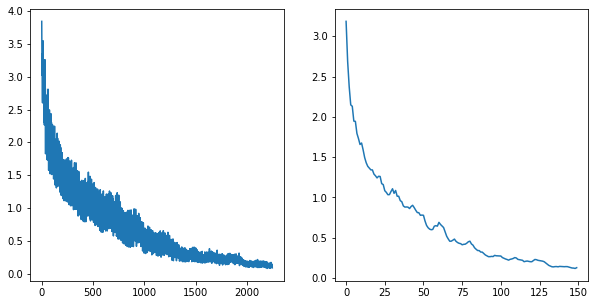

In [15]:
with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_02/epoch_losses.pkl', 'rb') as fp:
    epoch_losses = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_02/step_losses.pkl', 'rb') as fp:
    step_losses = pickle.load(fp)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

print(min(step_losses))

In [17]:
with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_02/X.pkl', 'rb') as fp:
    X = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_02/Y.pkl', 'rb') as fp:
    Y = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis/Code/ManojKolpeThesis/src/segmentation/unet/result/experiment_02/Y_pred.pkl', 'rb') as fp:
    Y_pred = pickle.load(fp)

In [18]:
print(X.shape)
print(Y.shape)
print(Y_pred.shape)

(8, 3, 240, 320)
(8, 240, 320)
(8, 240, 320)


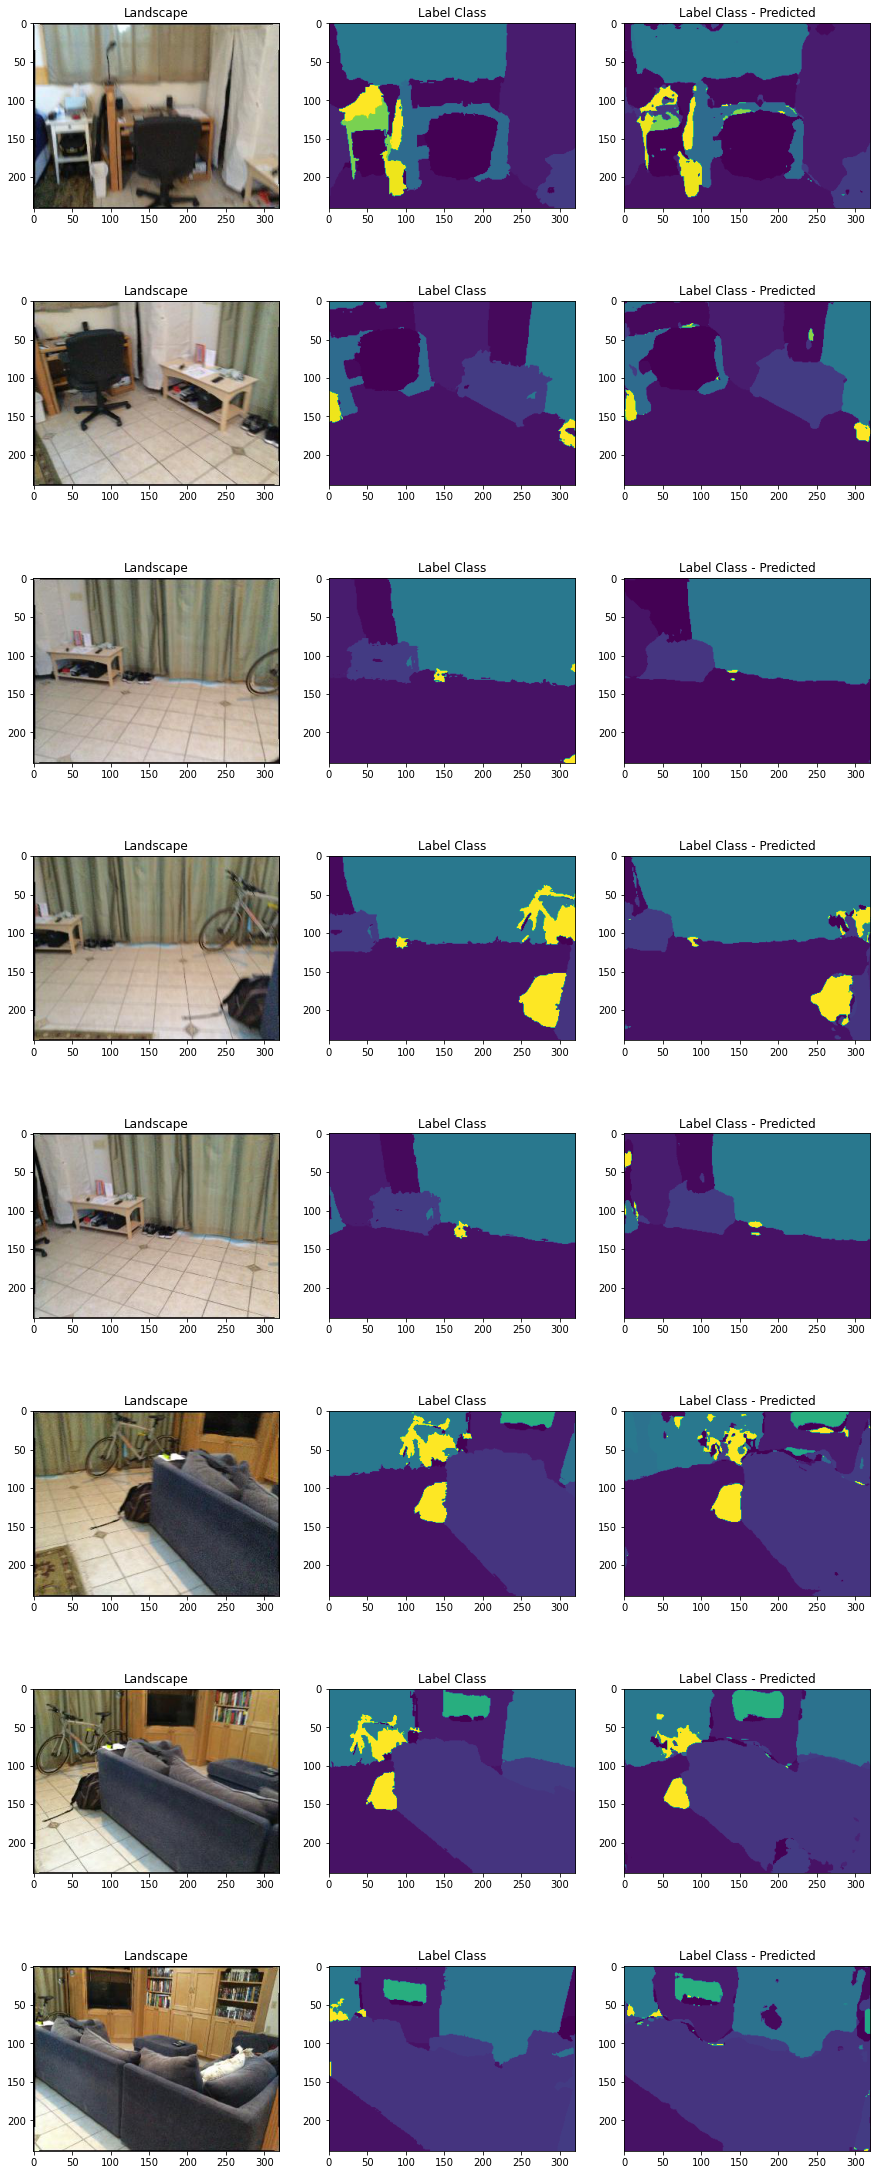

In [19]:
test_batch_size = 8
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(torch.from_numpy(X[i])).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i]
    label_class_predicted = Y_pred[i]
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [20]:
x = IoU(num_classes=41)
x.add(torch.from_numpy(Y_pred), torch.from_numpy(Y))
iou, meaniou = x.value()

In [21]:
print(len(iou))
print(type(iou))
print(iou.shape)
print(iou)
meaniou

41
<class 'numpy.ndarray'>
(41,)
[0.67691251 0.70061651 0.9593936  0.86910757 0.69208103        nan
 0.86981464 0.61123397 0.         0.                nan        nan
 0.                nan 0.72380722 0.78159854 0.9064655         nan
 0.                nan        nan        nan        nan        nan
 0.         0.73403042        nan        nan        nan        nan
        nan        nan 0.3056443  0.         0.                nan
        nan        nan        nan 0.57425743 0.46706619]


0.47009663923615674

In [47]:
def plot_data(dataset):
#     dataset = "/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/"

    classes = []
    for i in dataset:
        classes.append(np.array(i).flatten())

    print("Number of images:", len(classes))
    print("Shape of single image:", np.array(i).shape)

    flat_list = [x for xs in classes for x in xs]
    print("Total number of pixel in entire dataset:", len(flat_list))
    counted = dict(Counter(flat_list))
    print("Label data:")
    print(counted)

    factor=1.0/sum(counted.values())
    normalised_d = {k: float("{:.4f}".format(v*factor)) for k, v in counted.items() }
    
    print(normalised_d)
    plt.figure(figsize=(16,9))
    ax = sns.barplot(list(normalised_d.keys()), list(normalised_d.values()))
    ax.bar_label(ax.containers[0])
    ax.set_title('Class label distribution')
    ax.set_ylabel('Normalized number of pixels per class')
    ax.set_xlabel('Lables')

Number of images: 8
Shape of single image: (240, 320)
Total number of pixel in entire dataset: 614400
Label data:
{1: 25783, 16: 129415, 3: 57992, 14: 11295, 0: 18179, 40: 16381, 32: 1791, 4: 2065, 7: 27705, 39: 1535, 2: 197827, 6: 94710, 25: 4214, 15: 25508}
{1: 0.042, 16: 0.2106, 3: 0.0944, 14: 0.0184, 0: 0.0296, 40: 0.0267, 32: 0.0029, 4: 0.0034, 7: 0.0451, 39: 0.0025, 2: 0.322, 6: 0.1542, 25: 0.0069, 15: 0.0415}


/home/latai/anaconda3/envs/latai/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


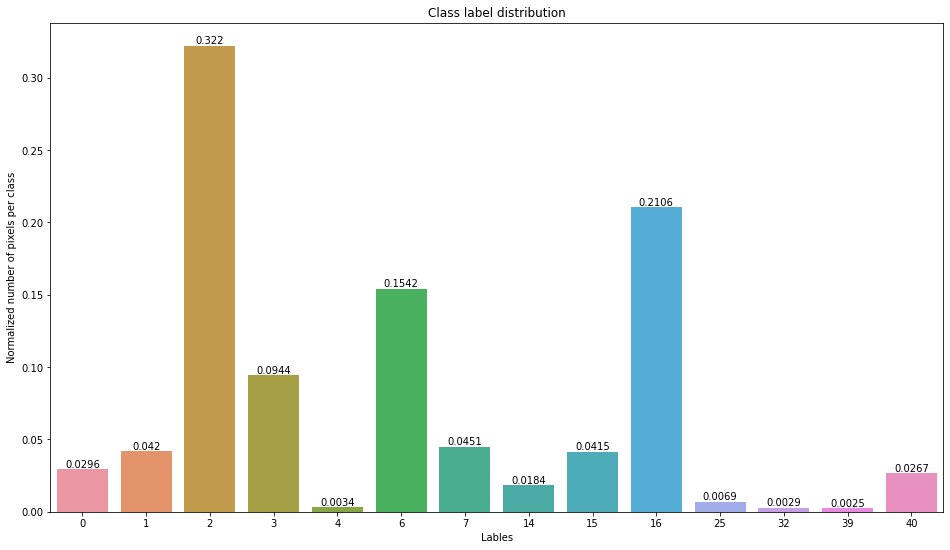

In [48]:
plot_data(Y)

Number of images: 8
Shape of single image: (240, 320)
Total number of pixel in entire dataset: 614400
Label data:
{1: 28283, 16: 125203, 3: 52990, 9: 178, 15: 26406, 8: 14, 0: 20883, 7: 30583, 14: 10094, 40: 10792, 6: 95639, 34: 42, 32: 661, 2: 202193, 4: 2529, 33: 277, 39: 2122, 24: 554, 12: 3, 25: 4907, 18: 47}
{1: 0.046, 16: 0.2038, 3: 0.0862, 9: 0.0003, 15: 0.043, 8: 0.0, 0: 0.034, 7: 0.0498, 14: 0.0164, 40: 0.0176, 6: 0.1557, 34: 0.0001, 32: 0.0011, 2: 0.3291, 4: 0.0041, 33: 0.0005, 39: 0.0035, 24: 0.0009, 12: 0.0, 25: 0.008, 18: 0.0001}


/home/latai/anaconda3/envs/latai/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


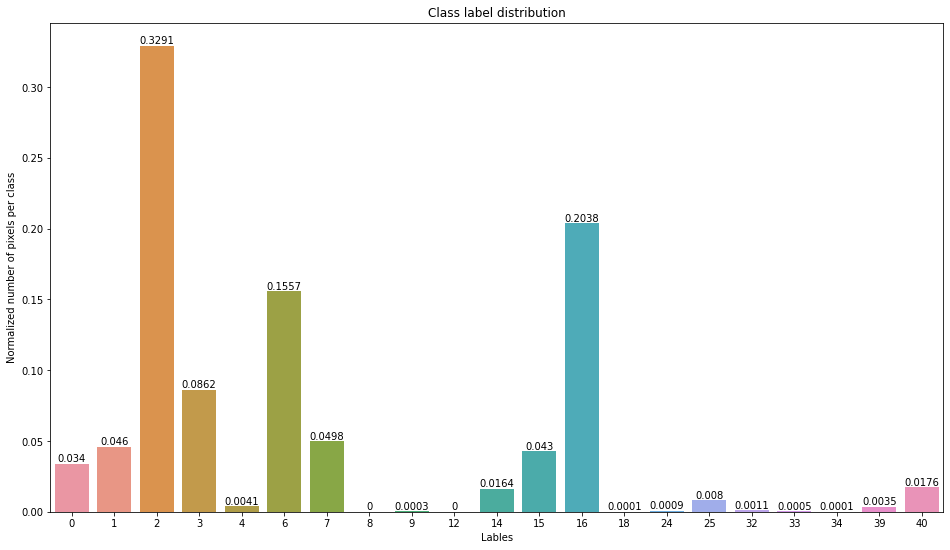

In [49]:
plot_data(Y_pred)

## Experimental code

In [71]:
def iou_numpy(outputs: np.array, labels: np.array):
#     outputs = outputs.squeeze(1)
    SMOOTH = 1e-6
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    print(iou)
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()

In [72]:
iou_numpy(Y_pred, Y)

[0.24524932 0.50681861 0.70392665 0.60783638 0.67995849 0.6022583
 0.46126984 0.44303682]


array([0. , 0.1, 0.5, 0.3, 0.4, 0.3, 0. , 0. ])

In [74]:
class Metric(object):
    """Base class for all metrics.

    From: https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py
    """
    def reset(self):
        pass

    def add(self):
        pass

    def value(self):
        pass

class ConfusionMatrix(Metric):
    """Constructs a confusion matrix for a multi-class classification problems.

    Does not support multi-label, multi-class problems.

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem.
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.

    Modified from: https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
    """

    def __init__(self, num_classes, normalized=False):
        super().__init__()

        self.conf = np.ndarray((num_classes, num_classes), dtype=np.int64)
        self.normalized = normalized
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.conf.fill(0)

    def add(self, predicted, target):
        """Computes the confusion matrix

        The shape of the confusion matrix is K x K, where K is the number
        of classes.

        Keyword arguments:
        - predicted (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        predicted scores obtained from the model for N examples and K classes,
        or an N-tensor/array of integer values between 0 and K-1.
        - target (Tensor or numpy.ndarray): Can be an N x K tensor/array of
        ground-truth classes for N examples and K classes, or an N-tensor/array
        of integer values between 0 and K-1.

        """
        # If target and/or predicted are tensors, convert them to numpy arrays
        if torch.is_tensor(predicted):
            predicted = predicted.cpu().numpy()
        if torch.is_tensor(target):
            target = target.cpu().numpy()

        assert predicted.shape[0] == target.shape[0], \
            'number of targets and predicted outputs do not match'

        if np.ndim(predicted) != 1:
            assert predicted.shape[1] == self.num_classes, \
                'number of predictions does not match size of confusion matrix'
            predicted = np.argmax(predicted, 1)
        else:
            assert (predicted.max() < self.num_classes) and (predicted.min() >= 0), \
                'predicted values are not between 0 and k-1'

        if np.ndim(target) != 1:
            assert target.shape[1] == self.num_classes, \
                'Onehot target does not match size of confusion matrix'
            assert (target >= 0).all() and (target <= 1).all(), \
                'in one-hot encoding, target values should be 0 or 1'
            assert (target.sum(1) == 1).all(), \
                'multi-label setting is not supported'
            target = np.argmax(target, 1)
        else:
            assert (target.max() < self.num_classes) and (target.min() >= 0), \
                'target values are not between 0 and k-1'

        # hack for bincounting 2 arrays together
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(
            x.astype(np.int64), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        self.conf += conf

    def value(self):
        """
        Returns:
            Confustion matrix of K rows and K columns, where rows corresponds
            to ground-truth targets and columns corresponds to predicted
            targets.
        """
        if self.normalized:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self.conf

class IoU(Metric):
    """Computes the intersection over union (IoU) per class and corresponding
    mean (mIoU).

    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:

        IoU = true_positive / (true_positive + false_positive + false_negative).

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    - ignore_index (int or iterable, optional): Index of the classes to ignore
    when computing the IoU. Can be an int, or any iterable of ints.
    """

    def __init__(self, num_classes, normalized=False, ignore_index=None):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized)

        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)
        else:
            try:
                self.ignore_index = tuple(ignore_index)
            except TypeError:
                raise ValueError("'ignore_index' must be an int or iterable")

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):
        """Adds the predicted and target pair to the IoU metric.

        Keyword arguments:
        - predicted (Tensor): Can be a (N, K, H, W) tensor of
        predicted scores obtained from the model for N examples and K classes,
        or (N, H, W) tensor of integer values between 0 and K-1.
        - target (Tensor): Can be a (N, K, H, W) tensor of
        target scores for N examples and K classes, or (N, H, W) tensor of
        integer values between 0 and K-1.

        """
        # Dimensions check
        assert predicted.size(0) == target.size(0), \
            'number of targets and predicted outputs do not match'
        assert predicted.dim() == 3 or predicted.dim() == 4, \
            "predictions must be of dimension (N, H, W) or (N, K, H, W)"
        assert target.dim() == 3 or target.dim() == 4, \
            "targets must be of dimension (N, H, W) or (N, K, H, W)"

        # If the tensor is in categorical format convert it to integer format
        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):
        """Computes the IoU and mean IoU.

        The mean computation ignores NaN elements of the IoU array.

        Returns:
            Tuple: (IoU, mIoU). The first output is the per class IoU,
            for K classes it's numpy.ndarray with K elements. The second output,
            is the mean IoU.
        """
        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)

In [77]:



class IoU(Metric):
    """Computes the intersection over union (IoU) per class and corresponding
    mean (mIoU).

    Intersection over union (IoU) is a common evaluation metric for semantic
    segmentation. The predictions are first accumulated in a confusion matrix
    and the IoU is computed from it as follows:

        IoU = true_positive / (true_positive + false_positive + false_negative).

    Keyword arguments:
    - num_classes (int): number of classes in the classification problem
    - normalized (boolean, optional): Determines whether or not the confusion
    matrix is normalized or not. Default: False.
    - ignore_index (int or iterable, optional): Index of the classes to ignore
    when computing the IoU. Can be an int, or any iterable of ints.
    """

    def __init__(self, num_classes, normalized=False, ignore_index=None):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized)

        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)
        else:
            try:
                self.ignore_index = tuple(ignore_index)
            except TypeError:
                raise ValueError("'ignore_index' must be an int or iterable")

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):
        """Adds the predicted and target pair to the IoU metric.

        Keyword arguments:
        - predicted (Tensor): Can be a (N, K, H, W) tensor of
        predicted scores obtained from the model for N examples and K classes,
        or (N, H, W) tensor of integer values between 0 and K-1.
        - target (Tensor): Can be a (N, K, H, W) tensor of
        target scores for N examples and K classes, or (N, H, W) tensor of
        integer values between 0 and K-1.

        """
        # Dimensions check
        assert predicted.size(0) == target.size(0), \
            'number of targets and predicted outputs do not match'
        assert predicted.dim() == 3 or predicted.dim() == 4, \
            "predictions must be of dimension (N, H, W) or (N, K, H, W)"
        assert target.dim() == 3 or target.dim() == 4, \
            "targets must be of dimension (N, H, W) or (N, K, H, W)"

        # If the tensor is in categorical format convert it to integer format
        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):
        """Computes the IoU and mean IoU.

        The mean computation ignores NaN elements of the IoU array.

        Returns:
            Tuple: (IoU, mIoU). The first output is the per class IoU,
            for K classes it's numpy.ndarray with K elements. The second output,
            is the mean IoU.
        """
        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)

In [83]:
x = IoU(num_classes=40)
x.add(torch.from_numpy(Y_pred), torch.from_numpy(Y))
iou, meaniou = x.value()

In [124]:
print(len(iou))
print(type(iou))
print(iou.shape)
print(iou)
meaniou

40
<class 'numpy.ndarray'>
(40,)
[0.         0.         0.         0.04130485 0.                nan
        nan 0.         0.         0.16397519 0.00747302        nan
        nan 0.         0.                nan 0.         0.42121932
 0.         0.67921071 0.         0.                nan 0.
 0.         0.         0.         0.         0.00415977        nan
 0.83742008 0.         0.         0.         0.01031257 0.
 0.         0.14287174 0.         0.00588543]


0.07011614182179084

In [93]:
summed_value = 0
for i in iou:
#     print(type(i))
    if str(i)!='nan':
        summed_value+=i

In [94]:
summed_value

2.3138326801190976

In [97]:
from collections import Counter

words = [5,5,2,1,1]

print(Counter(words).keys()) # equals to list(set(words))
print(Counter(words).values()) 

dict_keys([5, 2, 1])
dict_values([2, 1, 2])


In [99]:
for k, v in sorted(Counter(words)).items():
    print(k, v)

AttributeError: 'list' object has no attribute 'items'

In [100]:
sorted(Counter(words))

[1, 2, 5]

In [34]:
sample_image_label = Image.open('0.png')
np.array(sample_image_label).shape

(240, 320)

In [111]:
for k,v in Counter(list(np.array(sample_image_label).flatten())).items():
    print(k,v)

16 11217
3 15043
1 12612
14 3911
0 7521
7 12741
2 13755


In [120]:
for k, v in Counter(list(Y[1].flatten())).items():
    print(k,v)

37 8262
19 6944
13 1442
33 678
9 8016
14 445
1 776
23 3660
38 36
39 5793
10 6682
25 44
16 144
26 147
2 18
36 5
3 1
20 211
27 283
28 138
35 12
30 32574
8 199
17 40
34 246
0 3
24 1


In [119]:
for k, v in Counter(list(Y_pred[1].flatten())).items():
    print(k,v)

37 19946
9 6202
19 5908
34 106
39 628
17 10028
3 326
21 7
10 208
30 33441


In [12]:
import pickle
import torch.nn as nn
import torch
with open('Y.pkl', 'rb') as fp:
    Y = pickle.load(fp)

with open('Y_pred.pkl', 'rb') as fp:
    Y_pred = pickle.load(fp)

with open('Y_o.pkl', 'rb') as fp:
    Y_o = pickle.load(fp)

with open('Y_pred_o.pkl', 'rb') as fp:
    Y_pred_o = pickle.load(fp)

In [8]:
criterion = nn.CrossEntropyLoss()
loss = criterion(torch.from_numpy(Y_pred), torch.from_numpy(Y))

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 4

In [9]:
Y_pred.shape

(16, 41, 240, 320)

In [10]:
Y.shape

(16, 240, 320, 3)

In [13]:
Y_o.shape

(16, 240, 320)

In [14]:
Y_pred_o.shape

(16, 40, 240, 320)

In [17]:
Y_new = Y.squeeze(1)
Y_new.shape

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [22]:
print(Y[0].shape)
print(Y_o[0].shape)

(240, 320, 3)
(240, 320)


In [23]:
Y_o[0]

array([[ 3,  3,  3, ..., 36, 36, 36],
       [ 3,  3,  3, ..., 36, 36, 36],
       [ 3,  3,  3, ..., 36, 36, 36],
       ...,
       [10,  2,  2, ..., 36, 36, 36],
       [10,  2,  2, ..., 36, 36, 36],
       [10,  2,  2, ..., 36, 36, 36]])

In [26]:
Y[0].reshape(-1, 3).shape

(76800, 3)

In [29]:
import numpy as np
from sklearn.cluster import KMeans

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)

num_classes = 40
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

label_model.predict(Y[0].reshape(-1, 3)).reshape(240, 320).shape

(240, 320)

In [35]:
label = Image.open('0.png')
label = np.array(label)

label_class = torch.Tensor(label).long()

In [36]:
label_class.shape

torch.Size([240, 320])

In [85]:
from torch.utils.data import Dataset

class scannet(Dataset):
    
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_fns = os.listdir(image_dir)
        self.label_fns = os.listdir(label_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        label_fn = self.label_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        print(image_fp)
        label_fp = os.path.join(self.label_dir, label_fn)
        print(label_fp)
        label = Image.open(label_fp)
        label = np.array(label)
        print(label.shape)
        cityscape, label = image, label
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label).long()
        return cityscape, label_class, 
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [53]:
train_dir_color = '/home/latai/Documents/Master_thesis_v2/data/test4/color_train/'
train_dir_label = '/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/'

dataset = scannet(train_dir_color, train_dir_label)
data_loader = DataLoader(dataset, batch_size=16)


In [54]:
for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X = X
        Y = Y
        break

/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/580.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/3120.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/720.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/3560.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/2120.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/1500.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/2200.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/1460.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/1800.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/1560.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/640.png
(240, 320)
/home/latai/Documents/Master_thesis_v2/data/test4/label_train_n/3580.png
(240, 

In [55]:
Y.shape

torch.Size([16, 240, 320])

In [86]:
test_batch_size = 8

val_dir_color = '/home/latai/Documents/Master_thesis_v2/data/test4/color_valid'
val_dir_label = '/home/latai/Documents/Master_thesis_v2/data/test4/label_valid'

dataset = scannet(val_dir_color, val_dir_label)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

X, Y = next(iter(data_loader))

/home/latai/Documents/Master_thesis_v2/data/test4/color_valid/5000.jpg
/home/latai/Documents/Master_thesis_v2/data/test4/label_valid/5000.jpg
(240, 320, 3)
/home/latai/Documents/Master_thesis_v2/data/test4/color_valid/4960.jpg
/home/latai/Documents/Master_thesis_v2/data/test4/label_valid/4960.jpg
(240, 320, 3)
/home/latai/Documents/Master_thesis_v2/data/test4/color_valid/5320.jpg
/home/latai/Documents/Master_thesis_v2/data/test4/label_valid/5320.jpg
(240, 320, 3)
/home/latai/Documents/Master_thesis_v2/data/test4/color_valid/4780.jpg
/home/latai/Documents/Master_thesis_v2/data/test4/label_valid/4780.jpg
(240, 320, 3)
/home/latai/Documents/Master_thesis_v2/data/test4/color_valid/4920.jpg
/home/latai/Documents/Master_thesis_v2/data/test4/label_valid/4920.jpg
(240, 320, 3)
/home/latai/Documents/Master_thesis_v2/data/test4/color_valid/5340.jpg
/home/latai/Documents/Master_thesis_v2/data/test4/label_valid/5340.jpg
(240, 320, 3)
/home/latai/Documents/Master_thesis_v2/data/test4/color_valid/50

# Result V2

0.07963877171278


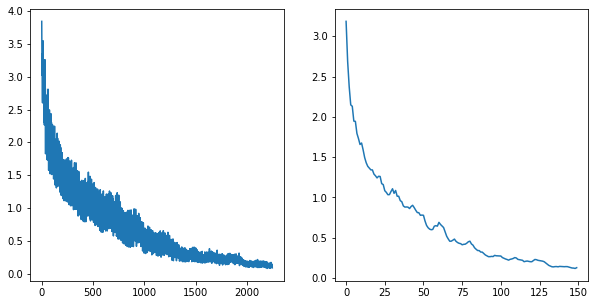

In [87]:
with open('/home/latai/Documents/Master_thesis_v2/code/Unet/result_v2/epoch_losses.pkl', 'rb') as fp:
    epoch_losses = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis_v2/code/Unet/result_v2/step_losses.pkl', 'rb') as fp:
    step_losses = pickle.load(fp)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

print(min(step_losses))

In [88]:
with open('/home/latai/Documents/Master_thesis_v2/code/Unet/result_v2/X.pkl', 'rb') as fp:
    X = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis_v2/code/Unet/result_v2/Y.pkl', 'rb') as fp:
    Y = pickle.load(fp)

with open('/home/latai/Documents/Master_thesis_v2/code/Unet/result_v2/Y_pred.pkl', 'rb') as fp:
    Y_pred = pickle.load(fp)

In [89]:
Y_pred.shape

(8, 240, 320)

(8, 240, 320)


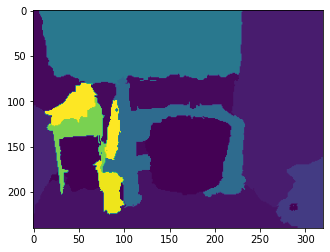

In [92]:
print(Y.shape)
plt.imshow(Y[0])

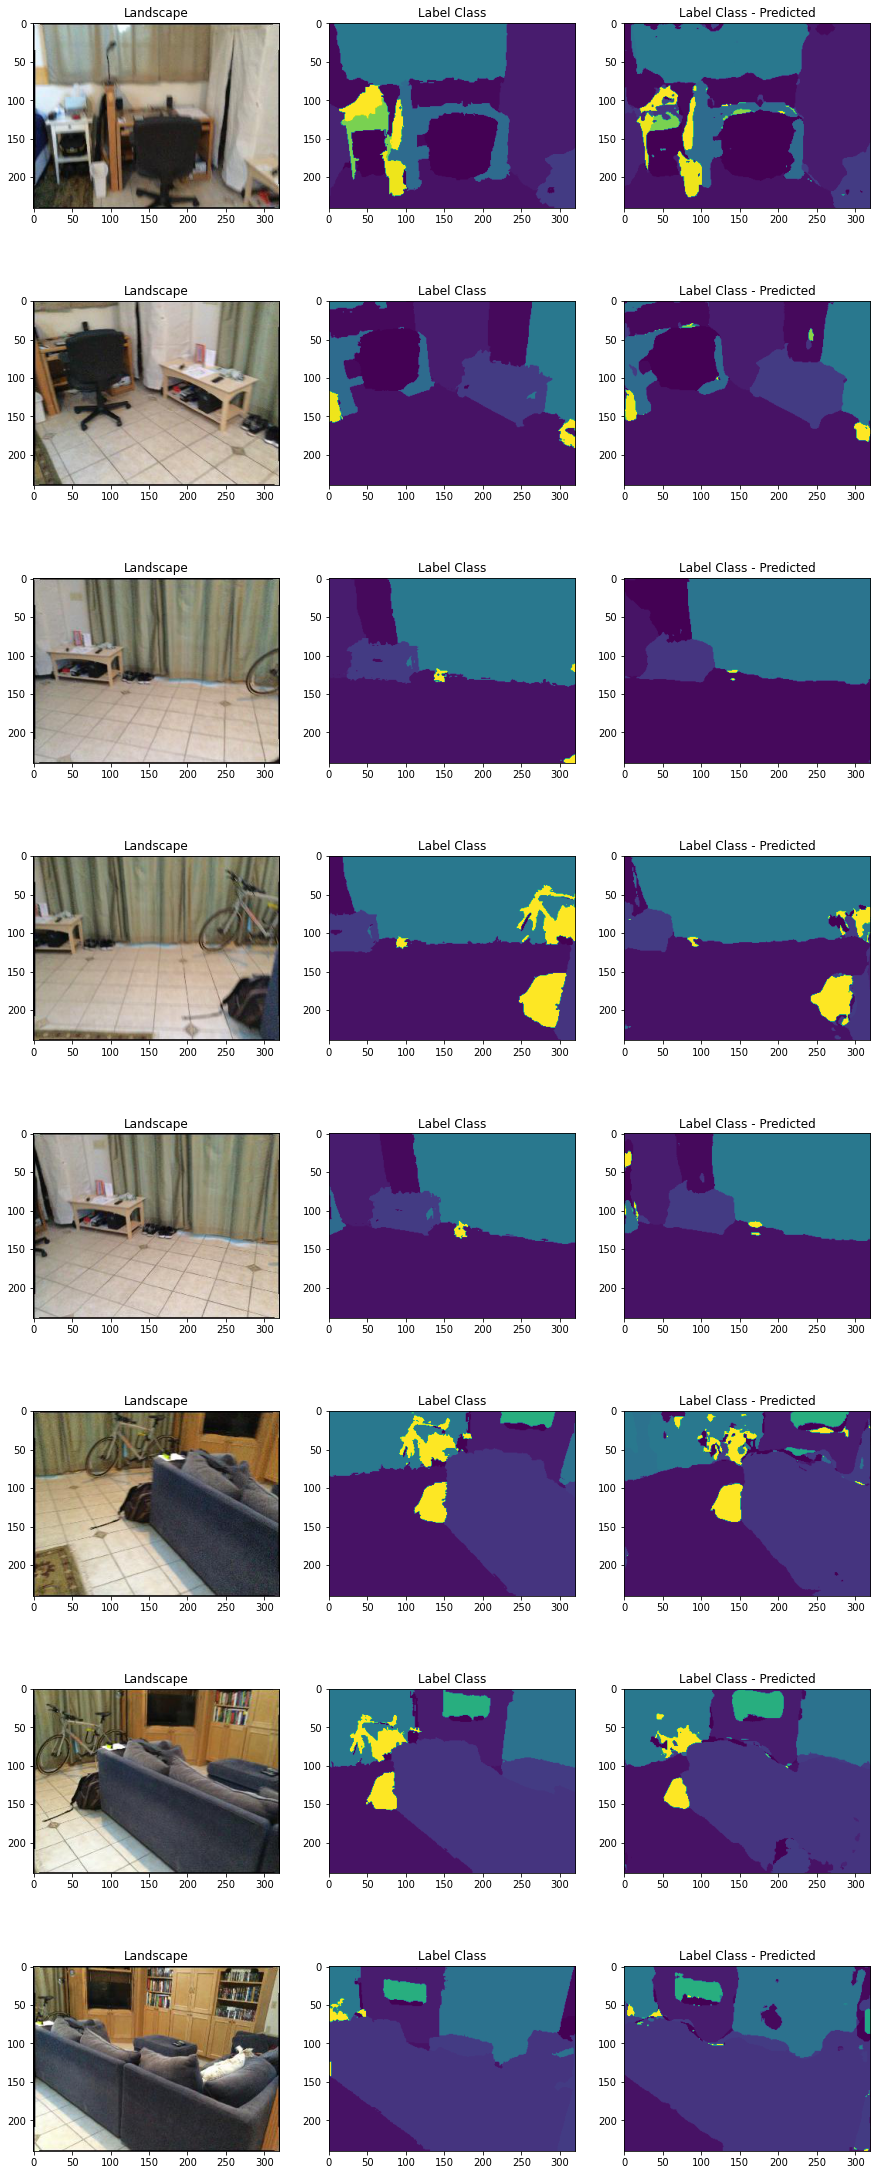

In [90]:
test_batch_size = 8
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(torch.from_numpy(X[i])).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i]
    label_class_predicted = Y_pred[i]
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [ ]:
val_dir_color = '/home/latai/Documents/Master_thesis_v2/data/test4/color_valid'
val_dir_label = '/home/latai/Documents/Master_thesis_v2/data/test4/label_valid'

image_fns = os.listdir(val_dir_color)
label_fns = os.listdir(val_dir_label)

